# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
import pytz
import datetime 
import cPickle as pickle
import astral
import astropy.time as aptime
from scipy import stats
from scipy import interpolate
import os
import glob

# Load env Data

In [17]:
pkl_file = open("GS-env-2014-19_p2.pkl", 'rb')
dictionary = pickle.load(pkl_file)
pkl_file.close()
dictionary_copy = copy.copy(dictionary)

# Merge GS env sensors

In [18]:
GS_env_data = dictionary_copy

sensor_list = ['T_M1+Y','T_M1-Y','T_TrussAirLow+X','T_TrussAirMid+X','T_TrussAirTop+X',
                 'T_TrussSurLow+X','T_TrussSurMid+X','T_TrussSurTop+X','T_twr']
    
n=0
for sensor in sensor_list:
    
    #  convert list to arrays and make an MJDOBS column
    GS_env_data[sensor]['vals'] = np.array(GS_env_data[sensor]['vals'])
    GS_env_data[sensor]['dts'] = np.array(GS_env_data[sensor]['dts'])
    GS_env_data[sensor]['MJDOBS'] = aptime.Time(GS_env_data[sensor]['dts'], format='datetime').mjd
    
    #  Get rid of zeros and outliers 
    cond1 = GS_env_data[sensor]['vals'] != 0.
    cond2 = np.abs(GS_env_data[sensor]['vals']) < 20.
    
    ind = np.where(cond1 & cond2)[0]
    
    GS_env_data[sensor]['vals'] = GS_env_data[sensor]['vals'][ind]
    GS_env_data[sensor]['dts'] = GS_env_data[sensor]['dts'][ind]
    GS_env_data[sensor]['MJDOBS'] = GS_env_data[sensor]['MJDOBS'][ind]
    
    #  merge other sensor data columns to M1+Y data table
    if n==0:
        df = pd.DataFrame(columns = ['dts','MJDOBS',sensor])
        df[sensor] = pd.Series(GS_env_data[sensor]['vals'])
        df['dts'] = pd.Series(GS_env_data[sensor]['dts'])
        df['MJDOBS'] = pd.Series(GS_env_data[sensor]['MJDOBS'])
        df = df.sort_values(by = ['dts'])
        n=1
   
    else:
        newdf = pd.DataFrame(columns = [sensor,'dts'])
        newdf[sensor] = pd.Series(GS_env_data[sensor]['vals'])
        newdf['dts'] = pd.Series(GS_env_data[sensor]['dts'])
        newdf = newdf.sort_values(by = ['dts'])
        
        df = pd.merge_asof(df,newdf, on='dts',tolerance=pd.Timedelta('30min'))
        
GS_env_data = df
GS_env_data['dts'] = GS_env_data['dts'].dt.tz_localize(pytz.UTC)

In [39]:
print len(GS_env_data)
for sensor in sensor_list:
    print sensor,sum(np.isfinite(GS_env_data[sensor]))  

315797
T_M1+Y 315797
T_M1-Y 315534
T_TrussAirLow+X 315783
T_TrussAirMid+X 315767
T_TrussAirTop+X 315434
T_TrussSurLow+X 310605
T_TrussSurMid+X 315778
T_TrussSurTop+X 314492
T_twr 315797


# Merge with GPI logs

In [5]:
path = os.environ["HOME"] + r'/Downloads/individual/'  
all_data_files = pd.Series(glob.glob(os.path.join(path, "*.log")))
data_files = all_data_files[all_data_files.str.contains('OMSS_AO_Bench_temperature|OE_Interior_Air_temperature|OMSS_Interface_Structure_temperature|OMSS_Mounting_Frame_temperature|Outside_OE_temperature')]

In [6]:
gpi_logs = pd.concat(map(lambda file: pd.read_csv(file, header=None, dtype={'0':object,'1': np.float64}, 
        names = ['dts',os.path.splitext(os.path.basename(file))[0]]), data_files),axis = 1)

gpi_logs = gpi_logs.iloc[:, ~gpi_logs.columns.duplicated()] # remove duplicate columns
#gpi_logs = gpi_logs.dropna(how = 'any')
gpi_logs['dts'] = pd.to_datetime(gpi_logs['dts']).dt.tz_localize(pytz.UTC) 
gpi_logs = gpi_logs.sort_values(by='dts').set_index(np.arange(len(gpi_logs)))

/Users/melisa/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [7]:
mask = (gpi_logs.loc[:,list(gpi_logs.columns != 'dts')] < 20.) & (gpi_logs.loc[:,list(gpi_logs.columns != 'dts')] != 0) & (gpi_logs.loc[:,list(gpi_logs.columns != 'dts')] > -20.)

mask['dts'] = True
gpi_logs = gpi_logs[mask]

In [8]:
GS_env_data = pd.merge_asof(GS_env_data,gpi_logs, on='dts',tolerance=pd.Timedelta('30min'))

Check values

In [22]:
GS_env_data.keys()

Index([u'dts', u'MJDOBS', u'T_M1+Y', u'T_M1-Y', u'T_TrussAirLow+X',
       u'T_TrussAirMid+X', u'T_TrussAirTop+X', u'T_TrussSurLow+X',
       u'T_TrussSurMid+X', u'T_TrussSurTop+X', u'T_twr',
       u'OE_Interior_Air_temperature', u'OMSS_AO_Bench_temperature',
       u'OMSS_Interface_Structure_temperature',
       u'OMSS_Mounting_Frame_temperature', u'Outside_OE_temperature'],
      dtype='object')

<IPython.core.display.Javascript object>


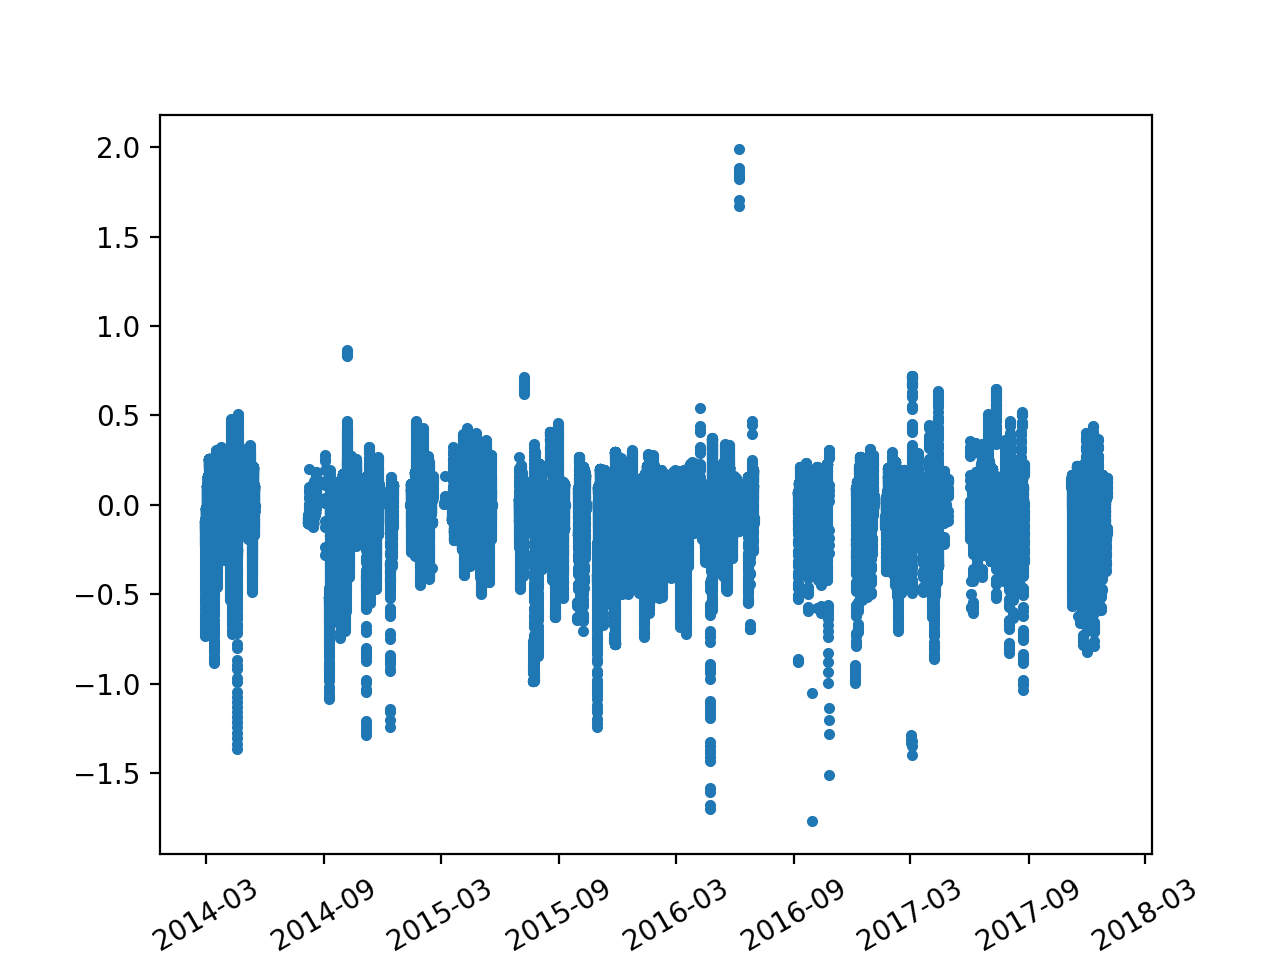

(array([735293., 735477., 735658., 735842., 736024., 736208., 736389.,
        736573., 736754.]), <a list of 9 Text xticklabel objects>)

In [191]:
%matplotlib notebook

plt.figure(1)
plt.plot(GS_env_data['dts'],GS_env_data['OE_Interior_Air_temperature_dT'],'.')
plt.xticks(rotation = 30)

# Apply offsets 

In [26]:
date = datetime.date(year = 2017, month = 8, day =3)

#  AO system requirements
cond1 = (GS_env_data['dts'] < date) 
ind = np.where(cond1)[0]

GS_env_data.loc[ind,'T_M1+Y'] = GS_env_data.loc[ind,'T_M1+Y'] + 4.67
GS_env_data.loc[ind,'T_M1-Y'] = GS_env_data.loc[ind,'T_M1-Y'] + 2.86
GS_env_data.loc[ind,'T_TrussAirLow+X'] = GS_env_data.loc[ind,'T_TrussAirLow+X'] + 1.5
GS_env_data.loc[ind,'T_TrussAirMid+X'] = GS_env_data.loc[ind,'T_TrussAirMid+X'] 
GS_env_data.loc[ind,'T_TrussAirTop+X'] = GS_env_data.loc[ind,'T_TrussAirTop+X'] 
GS_env_data.loc[ind,'T_TrussSurLow+X'] = GS_env_data.loc[ind,'T_TrussSurLow+X'] 
GS_env_data.loc[ind,'T_TrussSurMid+X'] = GS_env_data.loc[ind,'T_TrussSurMid+X'] 
GS_env_data.loc[ind,'T_TrussSurTop+X'] = GS_env_data.loc[ind,'T_TrussSurTop+X'] 

# Average mirror temperature

In [27]:
GS_env_data['M1_avg'] = (GS_env_data['T_M1+Y'] + GS_env_data['T_M1-Y'])/2

# Median dome temperature

Calculate dome temperature by computing mediam of all of the air temperture sensors. I also computed a median top, mid, and low dome temperatures. 

In [28]:
GS_env_data['dome'] = np.nanmedian(GS_env_data[['T_TrussAirLow+X','T_TrussAirMid+X','T_TrussAirTop+X']],axis = 1)

GS_env_data['dome_low'] = np.nanmedian(GS_env_data[['T_TrussAirLow+X']],axis = 1)

GS_env_data['dome_mid'] = np.nanmedian(GS_env_data[['T_TrussAirMid+X']],axis = 1)

GS_env_data['dome_top'] = np.nanmedian(GS_env_data[['T_TrussAirTop+X']],axis = 1)

/Users/MelisaT/anaconda/envs/python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:769: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


# Remove dates when GPI was off telescope

In [37]:
cond = (np.abs(GS_env_data['dome']-GS_env_data['T_twr']) < 5.) 
ind = np.where(cond)[0]

GS_env_data = GS_env_data.iloc[ind]
new_ind = np.arange(len(GS_env_data))
GS_env_data = GS_env_data.set_index(new_ind)  

# Add sunset, sunrise, night number columns to raw gpi data

In [29]:
def sunrise_and_sunset_info(dataframe):    
    
    #  Create colums with sunrise and sunset times in UTC time
    location = astral.Astral()['Santiago']
    timezone=location.timezone
    dataframe['sunset_utc'] = dataframe['dts'].apply(astral.Astral().sunset_utc,args=(location.latitude,location.longitude))
    dataframe['noon_utc'] = dataframe['dts'].apply(astral.Astral().solar_noon_utc,args=(location.longitude,))
    dataframe['sunrise_utc'] = dataframe['dts'].apply(astral.Astral().sunrise_utc,args=(location.latitude,location.longitude))

    #  Calculate time difference from sunset in hours
    dataframe['time_from_sunset'] = dataframe['dts']-dataframe['sunset_utc']

    #  Dates that use sunsets of the following day
    ind = np.where(dataframe['time_from_sunset'].dt.days == -1)[0]
    dataframe.loc[ind,'sunset_utc'] = (dataframe['dts'][ind]-datetime.timedelta(days =1)).apply(astral.Astral().sunset_utc,args=(location.latitude,location.longitude))

    #  Calculate time difference of observation from sunset after adjusting sunset times
    #  Calculate time difference of observation from sunset in hours
    dataframe['time_from_sunset'] = (dataframe['dts']-dataframe['sunset_utc'])
    dataframe['hours_from_sunset'] = dataframe['time_from_sunset'].dt.seconds/3600.

    #  Make changes when dates that use sunsets of following date
    ind1 = np.where(dataframe['sunset_utc'] > dataframe['dts'])[0]
    dataframe.loc[ind1,'sunset_utc'] = (dataframe.loc[ind1,'dts']-datetime.timedelta(days =1)).apply(astral.Astral().sunset_utc,args=(location.latitude,location.longitude))

    #  Make changes when dates that use sunrise of following date
    ind2 = np.where(dataframe['sunrise_utc'] > dataframe['dts'])[0]
    dataframe.loc[ind2,'sunrise_utc'] = (dataframe.loc[ind2,'dts']-datetime.timedelta(days =1)).apply(astral.Astral().sunrise_utc,args=(location.latitude,location.longitude))

    #  Make changes when dates that use noon of following date
    ind3 = np.where(dataframe['noon_utc'] > dataframe['dts'])[0]
    dataframe.loc[ind3,'noon_utc'] = (dataframe.loc[ind3,'dts']-datetime.timedelta(days =1)).apply(astral.Astral().solar_noon_utc,args=(location.longitude,))
    
    #  Calculate time difference of observation from sunset after adjusting sunset times
    #  Calculate time difference of observation from sunset in hours
    dataframe['time_from_sunset'] = (dataframe['dts']-dataframe['sunset_utc'])
    dataframe['hours_from_sunset'] = dataframe['time_from_sunset'].dt.seconds/3600.

    #  Calculate time difference of observation from sunrise after adjusting sunset times
    #  Calculate time difference of observation from sunrise in hours
    dataframe['time_from_sunrise'] = (dataframe['dts']-dataframe['sunrise_utc'])
    dataframe['hours_from_sunrise'] = dataframe['time_from_sunrise'].dt.seconds/3600.

    #  Calculate time difference of observation from noon after adjusting sunset times
    #  Calculate time difference of observation from noon in hours
    dataframe['time_from_noon'] = (dataframe['dts']-dataframe['noon_utc'])
    dataframe['hours_from_noon'] = dataframe['time_from_noon'].dt.seconds/3600.

    #  Assign column with night number
    dataframe['night_number'] = np.ones(len(dataframe))
    d0 = dataframe['sunset_utc'].dt.date
    d1 = np.roll(d0,-1)
    d1[-1] = np.nan
    extrema = np.where(d0 != d1)[0]
    start = 0
    val = 1

    for new_night in extrema:
        dataframe.loc[start:new_night,'night_number'] = val
        start = new_night + 1
        val = val + 1
        
    #  Create colums with  date information
    dataframe.loc[:,'year'] = dataframe.loc[:,'dts'].dt.year.values
    dataframe.loc[:,'month'] = dataframe.loc[:,'dts'].dt.month.values
    dataframe.loc[:,'hour'] = dataframe.loc[:,'hours_from_noon'].values.round(0)

    #  Select data only taken during night hours
    #night_hrs = np.where(dataframe['hours_from_sunset'] < dataframe['hours_from_sunrise'])[0]
    #dataframe = dataframe.iloc[night_hrs]
    
    #new_ind = np.arange(len(dataframe))
    dataframe = dataframe.set_index(new_ind)
    
    return dataframe

In [30]:
GS_env_data = sunrise_and_sunset_info(GS_env_data)

In [31]:
GS_env_data.columns


Index([u'dts', u'MJDOBS', u'T_M1+Y', u'T_M1-Y', u'T_TrussAirLow+X',
       u'T_TrussAirMid+X', u'T_TrussAirTop+X', u'T_TrussSurLow+X',
       u'T_TrussSurMid+X', u'T_TrussSurTop+X', u'T_twr',
       u'OE_Interior_Air_temperature', u'OMSS_AO_Bench_temperature',
       u'OMSS_Interface_Structure_temperature',
       u'OMSS_Mounting_Frame_temperature', u'Outside_OE_temperature',
       u'M1_avg', u'dome', u'dome_low', u'dome_mid', u'dome_top',
       u'sunset_utc', u'noon_utc', u'sunrise_utc', u'time_from_sunset',
       u'hours_from_sunset', u'time_from_sunrise', u'hours_from_sunrise',
       u'time_from_noon', u'hours_from_noon', u'night_number', u'year',
       u'month', u'hour'],
      dtype='object')

# Temperature drift

In [37]:
%matplotlib notebook 

def calc_dspline_fit(dataframe,temp):
    nights = pd.unique(dataframe['night_number'].values)
    df_dspline_fit = pd.DataFrame({'dspline_fit':[]})
    
    for night in nights:
        ind_night = np.where(dataframe['night_number']==night)[0]
        df_night = dataframe.iloc[ind_night]
        
        if len(df_night) < 4:
            dspline_fit = np.nan * np.ones(len(df_night))
            s = pd.DataFrame(dspline_fit,columns = ['dspline_fit']) #  used to append chunks at a time
            df_dspline_fit = df_dspline_fit.append(s, ignore_index=True)
                        
        else:    
            #  x and y data for nights with outliers removed      
            x = (df_night.loc[:,'MJDOBS']-df_night.loc[df_night.index[0],'MJDOBS'])*24
            y = pd.to_numeric(df_night[temp],errors='coerce')
            
            tck = interpolate.splrep(x,y,w = np.ones(len(np.isfinite(y))) * 1/(np.std(y)+.001))
            spline_fit = interpolate.splev(x, tck, der=0)#  evaluates the spline
            dspline_fit = interpolate.splev(x, tck, der=1)#  evaluates the derivative of the spline
            
            #  Append dspline_fit values and corresponding contrast values to df_dspline_fit for later use with plotting       
            s = pd.DataFrame(dspline_fit,columns = ['dspline_fit']) #  used to append chunks at a time
            df_dspline_fit = df_dspline_fit.append(s, ignore_index=True)  
    print('done with:', temp)
            
    return df_dspline_fit

In [30]:
col = list(gpi_logs.columns)[1:6] 
new_col = [x + '_dT' for x in col]
 
for i,j in zip(col,new_col):    
    GS_env_data[j] = calc_dspline_fit(GS_env_data,i) 

('done with:', 'OE_Interior_Air_temperature')
('done with:', 'OMSS_AO_Bench_temperature')
('done with:', 'OMSS_Interface_Structure_temperature')
('done with:', 'OMSS_Mounting_Frame_temperature')
('done with:', 'Outside_OE_temperature')


In [31]:
d = copy.copy(GS_env_data)
print len(d)
print sum(np.isfinite(d['OE_Interior_Air_temperature_dT']))  

128632
122450


# Save to CSV file

In [38]:
GS_env_data.to_csv('GS_env_20190211.csv',index=False)